In [306]:
%pylab inline 

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt



Populating the interactive namespace from numpy and matplotlib


Source links for data

-Medicaid Expansion http://www.kff.org/health-reform/state-indicator/state-activity-around-expanding-medicaid-under-the-affordable-care-act/?currentTimeframe=0&sortModel=%7B%22colId%22:%22Location%22,%22sort%22:%22asc%22%7D

(note: 

1.Coverage under the Medicaid expansion became effective January 1, 2014 in all states that have adopted the Medicaid expansion except for the following: Michigan (4/1/2014), New Hampshire (8/15/2014), Pennsylvania (1/1/2015), Indiana (2/1/2015), Alaska (9/1/2015), Montana (1/1/2016), and Louisiana (7/1/2016).

2.Arizona, Arkansas, Indiana, Iowa, Michigan, Montana, and New Hampshire have approved Section 1115 waivers for the Medicaid expansion. Arizona received CMS approval on September 30, 2016 to transition expansion coverage to 1115 waiver authority; implementation of the waiver provisions related to the expansion population are pending CMS approval of the state's Operational Protocol.

3.Wisconsin covers adults up to 100% FPL in Medicaid but did not adopt the ACA expansion.

)

-Mean Age by State: https://www.census.gov/cps/data/cpstablecreator.html

-Disability Enrollment data by State and total: https://www.ssa.gov/policy/docs/statcomps/di_asr/ [Year 2005-2015] /sect05.xlsx

-Census Regions and Divisions https://www2.census.gov/programs-surveys/popest/geographies/2011/state-geocodes-v2011.xls

-Per Capita GDP https://www.bea.gov/itable/iTable.cfm?ReqID=70&step=1#reqid=70&step=10&isuri=1&7003=1000&7035=-1&7004=naics&7005=1&7006=xx&7036=-1&7001=11000&7002=1&7090=70&7007=-1&7093=levels

-Per Capita Personal Income https://www.bea.gov/itable/iTable.cfm?ReqID=70&step=1#reqid=70&step=30&isuri=1&7003=1000&7035=-1&7004=naics&7022=21&7005=1&7023=0&7033=-1&7024=non-industry&7006=xx&7025=0&7026=xx&7027=-1&7036=-1&7001=421&7028=-1&7002=1&7031=0&7040=-1&7083=levels&7029=21&7090=70&7093=levels&7007=-1

-Wages, Compensation, Employment https://www.bea.gov/regional/downloadzip.cfm (Annual State Personal Income and Employment, all areas)

-ACA enrollment data
2014 https://aspe.hhs.gov/system/files/pdf/76806/ib_2014mar_enrollment.pdf
2015 https://aspe.hhs.gov/system/files/pdf/83656/ib_2015mar_enrollment.pdf
2016 (unused) https://aspe.hhs.gov/system/files/pdf/187866/Finalenrollment2016.pdf, https://aspe.hhs.gov/system/files/aspe-files/187871/marketplacestatefinal2016.xlsx



First, a basic series is provided by the Social Security Administration on total disability population at a nationwide level from 1996 through 2015.  As a first look at the data, we will put this in a dataframe and plot it.

In [307]:
df = pd.read_excel('.\SSI ACA data\SSI\SSI2015.xlsx', sheetname='Table 66',names=['Year', 'Beneficiaries'] , skiprows=4, skip_footer=52, parse_cols='A,C')

NATL_SSI = df.set_index('Year')

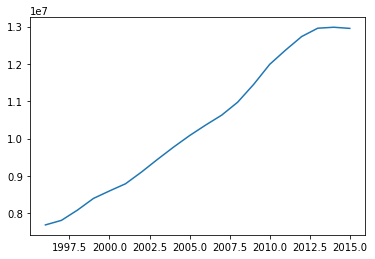

In [308]:
plt.plot (NATL_SSI.Beneficiaries)
NATL_SSI["d_pct_Beneficiaries"] = NATL_SSI.Beneficiaries.pct_change()
NATL_SSI.to_csv("./SSI ACA Data/NATL_SSI.csv")

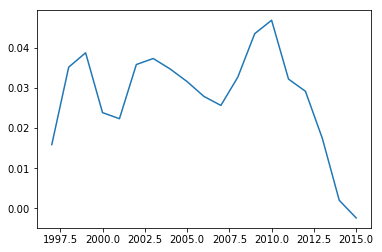

In [309]:
plt.plot (NATL_SSI.d_pct_Beneficiaries)

The plot shows a distinct drop off in the growth rate of disability beneficiaries corresponding to the timeframe of interest (roughly 2013-2015 as the ACA was phased in).  However this is a raw number and further exploration is required (for instance, population adjustment).

The SSA also provides state by state data in the 2004-2015 timeframe.  However they are all in separate spreadsheets so some code is required to put the data into a proper panel.  This panel will be the basis for the SSI information I will use in my project (with additional regressors from other data sources).  Previous commented out code above in the workbook was used for a mass download from SSA.gov of this information.

In [310]:
df = pd.DataFrame()

sht = 'Table 66'
for x in range(2005, 2016):
    if x == 2007: sht = 'Table 67' #they keep changing the tab name in these sheets :(
    if x == 2013: sht = 'Table 68'
    tmp = pd.read_excel('.\SSI ACA Data\SSI\SSI'+str(x)+'.xlsx', sheetname=sht, names=['State', 'Pop', 'Beneficiaries', 'Pct_Bene'], skiprows=3, skip_footer=9, parse_cols='A, C, D, E')
    tmp['Year'] = x
    df = df.append(tmp)

df = df.fillna('United States')
df = df.set_index('Year')


These datasheets provide state by state data, in levels and in percent of the population, for disability enrollments.  First lets re-run nationwide numbers as percentage of total population:

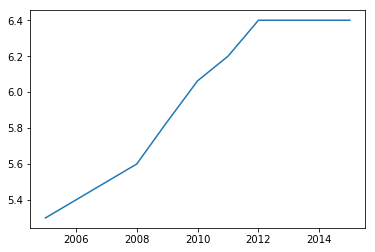

In [311]:
plt.plot(df[df.State=='United States'].Pct_Bene)

As a percentage of the population, we see the at-this-point well known increase in the rate of growth of disability enrollments beginning in the financial crisis era, and we also see a levelling of in roughly the ACA era.

The ACA was a federally funded program but much of the implementation (and some of the funding) was left up to the states.  With the panel data we've constructed, we can take an initial look at the effects by State.  The below states were selected blindly for this data exploration exercise, but I looked at ACA sympathetic and non ACA sympathetic states, populous and non populous just to get a sense of the variety of effects we might see.

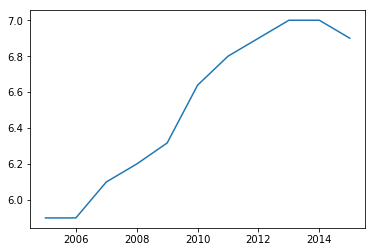

In [312]:
plt.plot(df[df.State=='Massachusetts'].Pct_Bene)

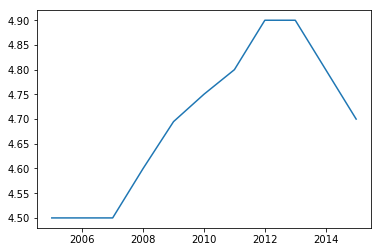

In [313]:
plt.plot(df[df.State=='California'].Pct_Bene)

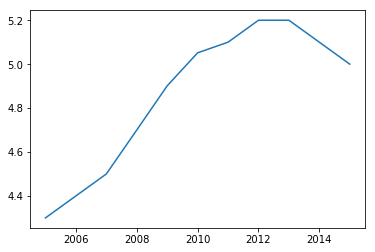

In [314]:
plt.plot(df[df.State=='Texas'].Pct_Bene)

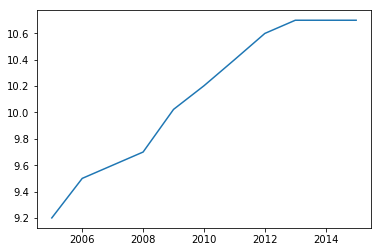

In [315]:
plt.plot(df[df.State=='Mississippi'].Pct_Bene)

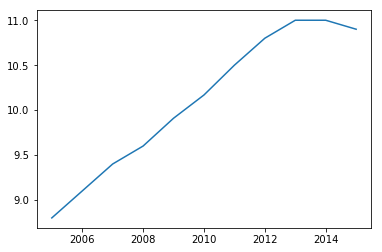

In [316]:
plt.plot(df[df.State=='Alabama'].Pct_Bene)

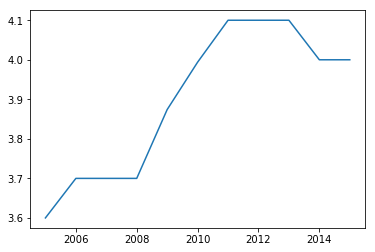

In [317]:
plt.plot(df[df.State=='Alaska'].Pct_Bene)

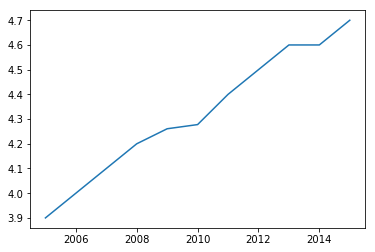

In [318]:
plt.plot(df[df.State=='Wyoming'].Pct_Bene)

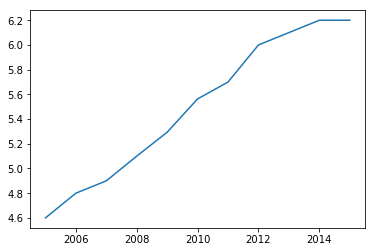

In [319]:
plt.plot(df[df.State=='Idaho'].Pct_Bene)

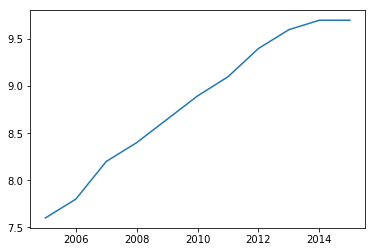

In [320]:
plt.plot(df[df.State=='Maine'].Pct_Bene)

In [321]:
PANEL_SSI = df


In [322]:
#read in per state GDP per capita figures
df = pd.read_csv('.\SSI ACA data\gsp_naics_all_PC.csv', engine='python', header=0 , skipfooter=11)
df = df.drop(['GeoFIPS', 'Region', 'ComponentId','ComponentName', 'IndustryId', 'IndustryClassification','Description'], axis=1)
#arrange as panel data (e.g. State, Year, Value)
df=df.set_index('GeoName').stack().reset_index().rename(columns = {"GeoName":"State", "level_1":"Year", 0:"GDPpercap"})
df['Year']=df['Year'].apply(pd.to_numeric)
#merge with the larger panel
PANEL_SSI = df.merge(PANEL_SSI.reset_index(), on=['State', 'Year'])

In [323]:
PANEL_SSI

,State,Year,GDPpercap,Pop,Beneficiaries,Pct_Bene
0,United States,2005,48062,186150307,9900578,5.300000
1,United States,2006,48880,188402570,10180455,5.400000
2,United States,2007,49126,189831466,10440382,5.500000
3,United States,2008,48401,191248160,10785828,5.600000
4,United States,2009,46680,192887745,11254927,5.834962
5,United States,2010,47287,194296087,11780167,6.062998
6,United States,2011,47587,196263504,12159875,6.200000
7,United States,2012,48157,197040596,12513314,6.400000
8,United States,2013,48504,197838893,12735462,6.400000
9,United States,2014,49203,199030227,12768929,6.400000


In [324]:
#Per capita personal income (same as above, load series, turn into panel data, load into the larger panel)
df = pd.read_csv('.\SSI ACA data\SA1_1929_2016.csv', engine='python', header=0, skipfooter=28)
df = df[df['Description']=='Per capita personal income (dollars) 2/'].drop(['GeoFIPS', 'Region', 'Table','LineCode', 'IndustryClassification','Description'], axis=1)
df=df.set_index('GeoName').stack().reset_index().rename(columns = {"GeoName":"State", "level_1":"Year", 0:"PIpercap"})
df['Year']=df['Year'].apply(pd.to_numeric)
df = df.replace(to_replace={'State': {'Alaska*':'Alaska', 'Hawaii*':'Hawaii'}})
PANEL_SSI = df.merge(PANEL_SSI.reset_index(), on=['State', 'Year'])

In [325]:
#Total Employment
df = pd.read_csv('.\SSI ACA data\SA25N_1998_2015__ALL_AREAS.csv', engine='python', header=0, skipfooter=948)
df = df[df['Description']=='Total employment (number of jobs)'].drop(['GeoFIPS', 'Region', 'Table','LineCode', 'IndustryClassification','Description'], axis=1)
df=df.set_index('GeoName').stack().reset_index().rename(columns = {"GeoName":"State", "level_1":"Year", 0:"TotalEmp"})
df['Year']=df['Year'].apply(pd.to_numeric)
PANEL_SSI = df.merge(PANEL_SSI.reset_index(), on=['State', 'Year']).drop(['level_0', 'index'], axis=1)

In [326]:
#Total Compensation of Employees
df = pd.read_csv('.\SSI ACA data\SA6N_1998_2016__ALL_AREAS.csv', engine='python', header=0, skipfooter=956)
df = df[df['Description']=='Compensation of employees (thousands of dollars) 1/'].drop(['GeoFIPS', 'Region', 'Table','LineCode', 'IndustryClassification','Description'], axis=1)
df = df.set_index('GeoName').stack().reset_index().rename(columns = {"GeoName":"State", "level_1":"Year", 0:"TotalComp"})
df['Year']=df['Year'].apply(pd.to_numeric)
PANEL_SSI = df.merge(PANEL_SSI.reset_index(), on=['State', 'Year']).drop(['index'], axis=1)

In [327]:
#Compensation per job
df = pd.read_csv('.\SSI ACA data\SA6N_1998_2016__ALL_AREAS.csv', engine='python', header=0, skipfooter=956)
df = df[df['Description']=='Average compensation per job (dollars) 3/'].drop(['GeoFIPS', 'Region', 'Table','LineCode', 'IndustryClassification','Description'], axis=1)
df=df.set_index('GeoName').stack().reset_index().rename(columns = {"GeoName":"State", "level_1":"Year", 0:"CompPerJob"})
df['Year']=df['Year'].apply(pd.to_numeric)
PANEL_SSI = df.merge(PANEL_SSI.reset_index(), on=['State', 'Year']).drop(['index'], axis=1)

In [328]:
#Wages
df = pd.read_csv('.\SSI ACA data\SA7N_1998_2016__ALL_AREAS.csv', engine='python', header=0, skipfooter=916)
df = df[df['Description']=='Wages and salaries by place of work (thousands of dollars)'].drop(['GeoFIPS', 'Region', 'Table','LineCode', 'IndustryClassification','Description'], axis=1)
df=df.set_index('GeoName').stack().reset_index().rename(columns = {"GeoName":"State", "level_1":"Year", 0:"TotalWages"})
df['Year']=df['Year'].apply(pd.to_numeric)
PANEL_SSI = df.merge(PANEL_SSI.reset_index(), on=['State', 'Year']).drop(['index'], axis=1)

In [329]:
#These are a little different than the above - I had to copy paste from a web application so the data
#is split between two sheets for average age
df = pd.read_excel('.\SSI ACA data\Avg Age by State and Year (census).xlsx', sheetname='Sheet1', 
                   names = ['StCode', '2009', '2010','2011', '2012', '2013', '2014', '2015'], 
                   parse_cols='A,C,E,G,I,K,M,O', skiprows = 3)
df2 = pd.read_excel('.\SSI ACA data\Avg Age by State and Year (census).xlsx', sheetname='Sheet2', 
                   names = ['StCode', '2005','2006', '2007', '2008'], 
                   parse_cols='A, I, K, M, O', skiprows = 3)
df = df2.merge(df, on='StCode')
#these numbers use state codes rather than names so we have to translate them back to names using a lookup
df2 = pd.read_excel('.\SSI ACA data\state codes.xls', sheetname='Sheet1', names = ['State', 'StCode'])
df = df2.merge(df, on='StCode',how='right')
df = df.drop(['StCode'], axis=1)
df = df.fillna('United States')
df = df.set_index("State").stack().reset_index().rename(columns = {"level_1":"Year", 0:"AvgAge"})
df["Year"] = df["Year"].apply(pd.to_numeric)
PANEL_SSI = df.merge(PANEL_SSI, on=['State', 'Year'])

In [330]:
#Poverty numbers are in the alternate columns in the average age datasheet, so this code is similar to above
df = pd.read_excel('.\SSI ACA data\Avg Age by State and Year (census).xlsx', sheetname='Sheet1', 
                   names = ['StCode', '2009', '2010','2011', '2012', '2013', '2014', '2015'], 
                   parse_cols='A,B, D, F, H, J, L, N', skiprows = 3)
df2 = pd.read_excel('.\SSI ACA data\Avg Age by State and Year (census).xlsx', sheetname='Sheet2', 
                   names = ['StCode', '2005','2006', '2007', '2008'], 
                   parse_cols='A, H, J, L, N', skiprows = 3)
df = df2.merge(df, on='StCode')
df2 = pd.read_excel('.\SSI ACA data\state codes.xls', sheetname='Sheet1', names = ['State', 'StCode'])
df = df2.merge(df, on='StCode',how='right')
df = df.drop(['StCode'], axis=1)
df = df.fillna('United States')
df = df.set_index("State").stack().reset_index().rename(columns = {"level_1":"Year", 0:"Pov"})
df["Year"] = df["Year"].apply(pd.to_numeric)
PANEL_SSI = df.merge(PANEL_SSI.reset_index(), on=['State', 'Year']).drop(['index'], axis=1)

In [331]:
#for some of our graphs, we want to display regional groups, so a lookup table for region is required
geocodes = pd.read_excel('.\SSI ACA Data\state-geocodes-v2011.xls', skiprows= 5, names = ['Region', 'Division', 'StateFIPS', 'Name'])
regions = geocodes[logical_and(geocodes["Division"]==0, geocodes["StateFIPS"]== 0)]
regions = regions[['Region', 'Name']].rename(columns = {"Name":"RegName"})
regions = regions.merge(geocodes[geocodes["StateFIPS"]!= 0], on="Region")
regions = regions.drop(["Region", "Division", "StateFIPS"], axis=1).rename(columns = {"Name": "State"})
regions["State"] = regions["State"].str.strip()
regions["RegName"] = regions["RegName"].str.strip()
PANEL_SSI = regions.merge(PANEL_SSI.reset_index(), how="right", on="State").drop(['index'], axis=1)

In [332]:
#Total Compensation and Wages are in 1000s of dollars.  Total employment is number of jobs
PANEL_SSI["TotalWages"] = PANEL_SSI["TotalWages"].apply(pd.to_numeric)
PANEL_SSI["CompPerJob"] = PANEL_SSI["CompPerJob"].apply(pd.to_numeric)
PANEL_SSI["TotalComp"] = PANEL_SSI["TotalComp"].apply(pd.to_numeric)
PANEL_SSI["TotalEmp"] = PANEL_SSI["TotalEmp"].apply(pd.to_numeric)
PANEL_SSI["PIpercap"] = PANEL_SSI["PIpercap"].apply(pd.to_numeric)
PANEL_SSI["CompPerCap"] = PANEL_SSI["TotalComp"]*1000/PANEL_SSI["Pop"]
PANEL_SSI["EmpPerCap"] = PANEL_SSI["TotalEmp"]/PANEL_SSI["Pop"]
PANEL_SSI["WagePerCap"] = PANEL_SSI["TotalWages"]*1000/PANEL_SSI["Pop"]

In [333]:
#PANEL_SSI = PANEL_SSI.set_index(['State', 'Year'])
#for most of our data points, we want the year over year percentage change, which is straightforward to generate in pandas
PANEL_SSI['d_pct_CompPerJob'] = PANEL_SSI["CompPerJob"].pct_change()
PANEL_SSI['d_pct_PIPerCap'] = PANEL_SSI["PIpercap"].pct_change()
PANEL_SSI['d_pct_GDPPerCap'] = PANEL_SSI["GDPpercap"].pct_change()
PANEL_SSI['d_pct_CompPerCap'] = PANEL_SSI["CompPerCap"].pct_change()
PANEL_SSI['d_pct_WagePerCap'] = PANEL_SSI["WagePerCap"].pct_change()
PANEL_SSI['d_pct_EmpPerCap'] = PANEL_SSI["EmpPerCap"].pct_change()
PANEL_SSI['d_pct_AvgAge'] = PANEL_SSI["AvgAge"].pct_change()
PANEL_SSI['d_pct_Pov'] = PANEL_SSI['Pov'].pct_change()
#Pct_Bene given in the workbook is one decimal place, so I elected to recalculate it using beneficiaries and population
PANEL_SSI['BenePerCap'] = PANEL_SSI["Beneficiaries"]/PANEL_SSI["Pop"]
PANEL_SSI['d_pct_BenePerCap'] = PANEL_SSI["BenePerCap"].pct_change()

In [334]:
PANEL_SSI['d_pct_CompPerJob_1'] = PANEL_SSI["d_pct_CompPerJob"].shift()
PANEL_SSI['d_pct_PIPerCap_1'] = PANEL_SSI["d_pct_PIPerCap"].shift()
PANEL_SSI['d_pct_GDPPerCap_1'] = PANEL_SSI["d_pct_GDPPerCap"].shift()
PANEL_SSI['d_pct_CompPerCap_1'] = PANEL_SSI["d_pct_CompPerCap"].shift()
PANEL_SSI['d_pct_WagePerCap_1'] = PANEL_SSI["d_pct_WagePerCap"].shift()
PANEL_SSI['d_pct_EmpPerCap_1'] = PANEL_SSI["d_pct_EmpPerCap"].shift()
PANEL_SSI['d_pct_AvgAge_1'] = PANEL_SSI["d_pct_AvgAge"].shift()
PANEL_SSI['d_pct_Pov_1'] = PANEL_SSI['Pov'].shift()
PANEL_SSI['d_pct_BenePerCap_1'] = PANEL_SSI["d_pct_BenePerCap"].shift()

In [335]:
PANEL_SSI = PANEL_SSI.reset_index()
#since our pct_change variables now have NaN for 2005, we will remove that year
PANEL_SSI = PANEL_SSI[PANEL_SSI["Year"] != 2005]
#excluding district of colombia
PANEL_SSI = PANEL_SSI[PANEL_SSI["State"] != "District of Columbia"]

In [337]:
PANEL_SSI['Pct_Bene'] = PANEL_SSI["Beneficiaries"]/PANEL_SSI["Pop"]
#output our panel to csv
PANEL_SSI.to_csv(".\SSI ACA Data\PANEL_SSI.csv")

In [295]:
#this data is cut and paste from a pdf, so each value is on its own line
df = pd.read_excel('.\SSI ACA Data\ACA Enroll cut paste.xlsx', header=None, sheetname='2014')

In [296]:
df2=pd.DataFrame()
#for 2014 data, the enrollments appear every 5th line
df2['State'] = [df.loc[n,0] for n in range(0,255,5)]
df2['Year'] = 2014
df2['ACA_Enroll'] = [df.loc[n,0] for n in range (4, 255,5)]

In [297]:
ACA_ENROLL = df2

In [298]:
df = pd.read_excel('.\SSI ACA Data\ACA Enroll cut paste.xlsx', header=None, sheetname='2015')
df2=pd.DataFrame()
#for 2015 data, the format was changed and the enrollments are in every 6th line
df2['State'] = [df.loc[n,0] for n in range(0,306,6)]
df2['Year'] = 2015
df2['ACA_Enroll'] = [df.loc[n,0] for n in range (1, 306,6)]

In [299]:
ACA_ENROLL = df2.append(ACA_ENROLL)

In [300]:
#strip out footnotes like "(1)" that are in the state names
ACA_ENROLL["State"] = ACA_ENROLL["State"].replace(regex=True, to_replace="[\(\)0-9]*", value="").str.strip()

In [301]:
#dummy variable for whether the state expanded medicaid under the ACA
df = pd.read_csv('.\SSI ACA Data\medicaid expansion.csv', engine="python", header =2, skipfooter=14)
df = df.rename(columns = {"Location":"State", "Current Status of Medicaid Expansion Decision":"MedExpDummy"})
df = df.drop("Footnotes", axis=1)
df = df.replace(dict({"MedExpDummy": {"Not Adopted":0, "Adopted":1}})).drop(0, axis=0)
df = df.set_index("State")

#5 expansion states didn't expand medicaid within the period of interest - see notes in source
df.loc["Pennsylvania", "MedExpDummy"] = 0
df.loc["Indiana", "MedExpDummy"] = 0
df.loc["Alaska", "MedExpDummy"] = 0
df.loc["Montana", "MedExpDummy"] = 0
df.loc["Louisiana", "MedExpDummy"] = 0
df = df.reset_index()
ACA_ENROLL = df.merge(ACA_ENROLL, on="State")

In [302]:
ACA_ENROLL = ACA_ENROLL.set_index(['State', 'Year']).sort_index()
ACA_ENROLL["d_pct_ACA_Enroll"] = ACA_ENROLL["ACA_Enroll"].pct_change()

In [303]:
ACA_ENROLL = ACA_ENROLL.reset_index()
ACA_ENROLL = ACA_ENROLL[ACA_ENROLL["Year"] == 2015]

In [304]:
ACA_ENROLL = ACA_ENROLL.merge(PANEL_SSI, on = ["State", "Year"])

In [305]:
ACA_ENROLL.to_csv(".\SSI ACA Data\ACA_ENROLL.csv")